### Preparing the dataset

In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn import tree
from sklearn.tree import export_text, export_graphviz, plot_tree
import graphviz
import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")
df = data[data['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [5]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
df.fillna(0, inplace=True)


In [7]:
df['median_house_value'] = np.log1p(df['median_house_value'])

In [8]:


df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [9]:
y_train = df_train['median_house_value'].values
del df_train['median_house_value']

y_val = df_val['median_house_value'].values
del df_val['median_house_value']

y_test = df_test['median_house_value'].values
del df_test['median_house_value']


In [10]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)


### Question 1

In [11]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_val)

mse_val = ((y_val - y_pred)**2).mean()
rmse_val = np.sqrt(mse_val)

print('Number of nodes = {0}'.format(dtr.tree_.node_count))
print('Parameters used: {}'.format(dtr.get_params()))
print('Decision Tree Regressor feature = {0}'.format(dtr.tree_.feature))
print('Decision Tree Regressor threshold = {0}'.format(dtr.tree_.threshold))
print('Validation RMSE = {0}'.format(rmse_val))
print('Feature importances: {0}'.format(dtr.feature_importances_))

print(export_text(dtr, feature_names=dv.get_feature_names()))

Number of nodes = 3
Parameters used: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Decision Tree Regressor feature = [ 5 -2 -2]
Decision Tree Regressor threshold = [ 0.5 -2.  -2. ]
Validation RMSE = 0.453464771320733
Feature importances: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



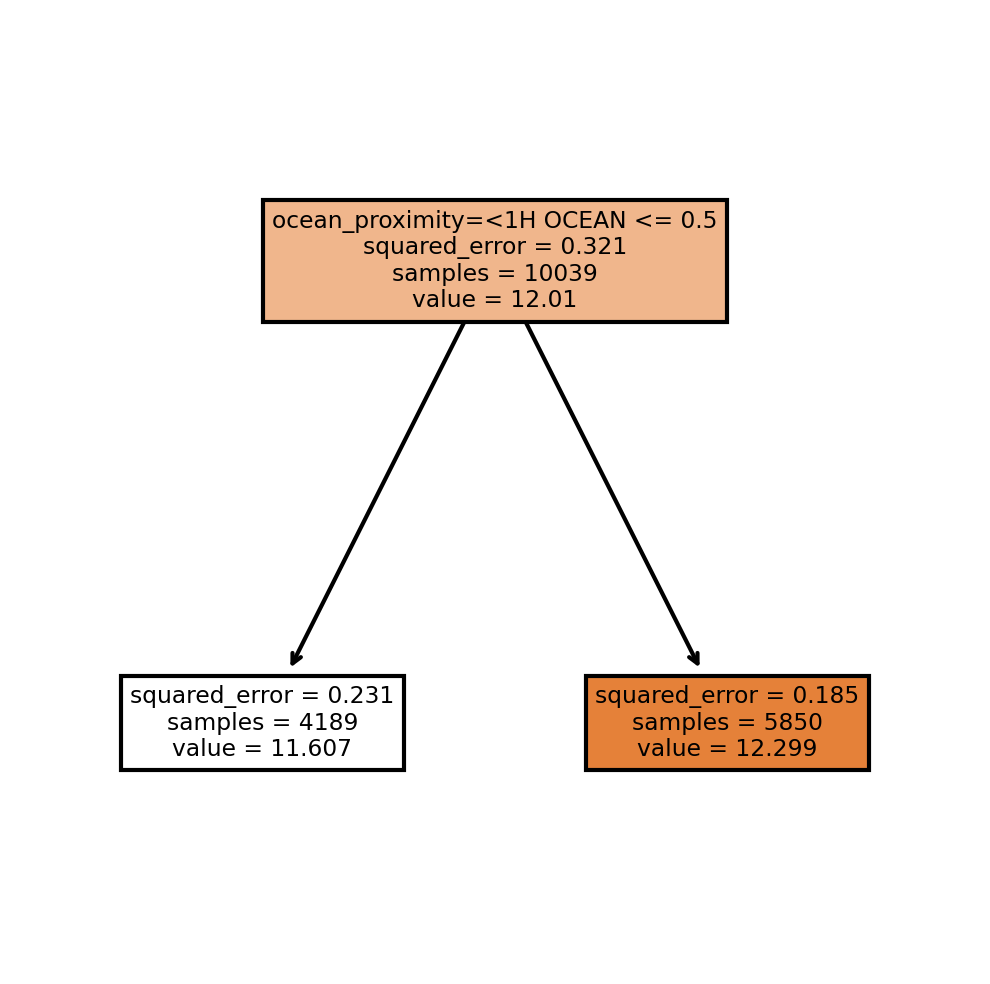

In [12]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)


plot_tree(dtr, feature_names=dv.get_feature_names(), filled=True)
plt.show()

answer is ocean_proximity

### Question 2

In [13]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

print('RMSE = {0}'.format(np.sqrt(((y_val - y_pred)**2).mean())))

RMSE = 0.23817740383441025


answer is 0.245

### Question 3

In [14]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred_val = rf.predict(X_val)
    rmse = np.sqrt(MSE(y_val, y_pred_val))
    
    scores.append((n, rmse))

In [15]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

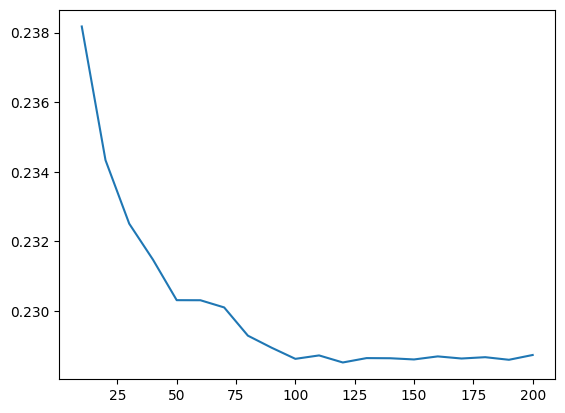

In [16]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

answer is 160

### Question 4

In [17]:
scores = []

for depth in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=depth,
                                   random_state=1)
        rf.fit(X_train, y_train)

        y_pred_val = rf.predict(X_val)
        rmse = np.sqrt(MSE(y_val, y_pred_val))

        scores.append((depth, n, rmse))

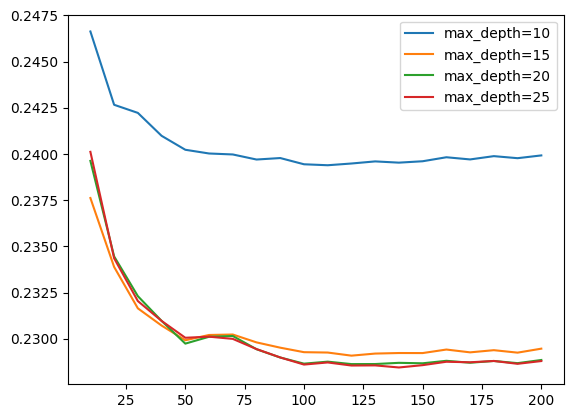

In [18]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

for depth in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == depth]
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % depth)

plt.legend()

answer is 25

### Question 5

In [19]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

print('RMSE = {0}'.format(np.sqrt(((y_val - y_pred)**2).mean())))
print('Feature importances: {0}'.format(rf.feature_importances_))


RMSE = 0.2396302193104849
Feature importances: [0.01620785 0.03219973 0.10025315 0.09087285 0.33447595 0.25500885
 0.11058958 0.02588287 0.01402574 0.02048344]


In [20]:
feature_importances = rf.feature_importances_
forestimp = pd.Series(feature_importances, index=dv.get_feature_names())
print(forestimp.sort_values(ascending=False))


median_income                0.334476
ocean_proximity=<1H OCEAN    0.255009
ocean_proximity=INLAND       0.110590
latitude                     0.100253
longitude                    0.090873
housing_median_age           0.032200
population                   0.025883
total_rooms                  0.020483
households                   0.016208
total_bedrooms               0.014026
dtype: float64


answer is median_income

### Question 6

In [21]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


In [25]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]



In [26]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)


[0]	train-rmse:8.07283	val-rmse:8.07651
[5]	train-rmse:1.38880	val-rmse:1.38640
[10]	train-rmse:0.32889	val-rmse:0.34221
[15]	train-rmse:0.21462	val-rmse:0.24322
[20]	train-rmse:0.19907	val-rmse:0.23663
[25]	train-rmse:0.18666	val-rmse:0.23175
[30]	train-rmse:0.17857	val-rmse:0.23016
[35]	train-rmse:0.17056	val-rmse:0.22797
[40]	train-rmse:0.16495	val-rmse:0.22752
[45]	train-rmse:0.15857	val-rmse:0.22576
[50]	train-rmse:0.15322	val-rmse:0.22505
[55]	train-rmse:0.14774	val-rmse:0.22421
[60]	train-rmse:0.14447	val-rmse:0.22453
[65]	train-rmse:0.14069	val-rmse:0.22443
[70]	train-rmse:0.13702	val-rmse:0.22375
[75]	train-rmse:0.13419	val-rmse:0.22326
[80]	train-rmse:0.13083	val-rmse:0.22370
[85]	train-rmse:0.12769	val-rmse:0.22377
[90]	train-rmse:0.12465	val-rmse:0.22381
[95]	train-rmse:0.12013	val-rmse:0.22295
[99]	train-rmse:0.11757	val-rmse:0.22287


In [30]:
y_pred = model.predict(dval)

In [31]:
print('RMSE = {0}'.format(np.sqrt(((y_val - y_pred)**2).mean())))

RMSE = 0.22287418238184248


In [32]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}


In [33]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]



In [34]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

[0]	train-rmse:10.37361	val-rmse:10.37944
[5]	train-rmse:6.13370	val-rmse:6.13448
[10]	train-rmse:3.63244	val-rmse:3.63061
[15]	train-rmse:2.15890	val-rmse:2.15629
[20]	train-rmse:1.29406	val-rmse:1.29236
[25]	train-rmse:0.79157	val-rmse:0.79274
[30]	train-rmse:0.50450	val-rmse:0.51020
[35]	train-rmse:0.34817	val-rmse:0.35994
[40]	train-rmse:0.26946	val-rmse:0.28806
[45]	train-rmse:0.23221	val-rmse:0.25643
[50]	train-rmse:0.21491	val-rmse:0.24292
[55]	train-rmse:0.20516	val-rmse:0.23641
[60]	train-rmse:0.19863	val-rmse:0.23242
[65]	train-rmse:0.19456	val-rmse:0.23047
[70]	train-rmse:0.19103	val-rmse:0.22920
[75]	train-rmse:0.18751	val-rmse:0.22763
[80]	train-rmse:0.18410	val-rmse:0.22625
[85]	train-rmse:0.18125	val-rmse:0.22537
[90]	train-rmse:0.17789	val-rmse:0.22478
[95]	train-rmse:0.17514	val-rmse:0.22352
[99]	train-rmse:0.17302	val-rmse:0.22305


In [35]:
y_pred = model.predict(dval)

In [36]:
print('RMSE = {0}'.format(np.sqrt(((y_val - y_pred)**2).mean())))

RMSE = 0.2230486127204922


answer is 0,3